In [ ]:
!mkdir /content/data

In [ ]:
!unzip -q /content/drive/MyDrive/Ego_vision.zip -d /content/data

In [ ]:
!pip install ptflops

  Preparing metadata (setup.py) ... done
  Created wheel for ptflops: filename=ptflops-0.7-py3-none-any.whl size=11076 sha256=0e88faf2265264fb380620dced20c4bc511a18113c4fbc3ec26bf1818c19b8bf
  Stored in directory: /root/.cache/pip/wheels/b9/54/3b/f84523431ce82e08462644d279c0e13a51a00236e237e6bc7e
Successfully built ptflops


In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 64.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.4 MB/s eta 0:00:00


In [ ]:
!pip install torch_optimizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 9.5 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import json
import time
import random
import logging
import easydict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
from pathlib import Path
from natsort import natsorted
from os.path import join as opj
from ptflops import get_model_complexity_info
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold
from PIL import Image

import timm
import torch
import torch.nn as nn
import torch_optimizer as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, grad_scaler
from torchvision import transforms

import warnings
warnings.filterwarnings('ignore')

In [ ]:
args = easydict.EasyDict(
    {'exp_num':'0',
     'experiment':'Base',
     'tag':'Default',

     # Path settings
     'data_path':'./data',
     'fold':4,
     'Kfold':5,
     'model_path':'results/',

     # Model parameter settings
     'encoder_name':'regnety_040',
     'drop_path_rate':0.2,

     # Training parameter settings
     ## Base Parameter
     'img_size':288,
     'batch_size':16,
     'epochs':60,
     'optimizer':'Lamb',
     'initial_lr':5e-6,
     'weight_decay':1e-3,

     ## Augmentation
     'aug_ver':2,
     'flipaug_ratio':0.3,
     'margin':50,
     'random_margin':True,

     ## Scheduler
     'scheduler':'cycle',
     'warm_epoch':5,
     ### Cosine Annealing
     'min_lr':5e-6,
     'tmax':145,
     ### OnecycleLR
     'max_lr':1e-3,

     ## etc.
     'patience':50,
     'clipping':None,

     # Hardware settings
     'amp':True,
     'multi_gpu':False,
     'logging':False,
     'num_workers':4,
     'seed':42
    })

In [ ]:
def crop_image(imges, point, margin=100):
    image = np.array(Image.open(imges).convert('RGB'))
    point = point['data']
    max_point = np.max(np.array(point), axis=0).astype(int) + margin
    min_point = np.min(np.array(point), axis=0).astype(int) - margin
    max_point = max_point[:-1] # remove Z order
    min_point = min_point[:-1] # remove Z order

    max_x, max_y = max_point
    min_x, min_y = min_point
    max_y += margin  # 손목까지

    # 데이터 포인트의 크기가 원 이미지를 넘어서는 경우를 방지
    max_x = max_x if max_x < 1920 else 1920
    max_y = max_y if max_y < 1080 else 1080
    min_x = min_x if min_x > 0 else 0
    min_y = min_y if min_y > 0 else 0

    crop_image = image[min_y:max_y, min_x:max_x]

    return crop_image

In [ ]:
train_path = './data/train'
train_folders = natsorted(glob(train_path + '/*'))

answers = []
for train_folder in train_folders:
    json_path = glob(train_folder + '/*.json')[0]
    js = json.load(open(json_path))
    cat = js.get('action')[0]
    cat_name = js.get('action')[1]

    images_list = glob(train_folder + '/*.png')
    for image_name in images_list:
        answers.append([image_name, cat, cat_name])

answers = pd.DataFrame(answers, columns = ['train_path','answer', 'answer_name'])
answers.to_csv('./data/df_train.csv', index=False)

# 클래스가 1개뿐인 폴더들 Augmentation해서 이미지 생성후 dataframe재정의
# 새롭게 정의한 dataframe을 학습에 이용시 약간의 성능향상을 확인할 수 있었음.
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)

data_path = './data'
df_train = pd.read_csv(opj(data_path, 'df_train.csv'))
df_info = pd.read_csv(opj(data_path, 'hand_gesture_pose.csv'))
df_train = df_train.merge(df_info[['pose_id', 'gesture_type', 'hand_type']],
                        how='left', left_on='answer', right_on='pose_id')

save_folder = 'train'
for i in range(649, 649+5):
    if not os.path.exists(opj(data_path, save_folder, str(i))):
        os.makedirs(opj(data_path, save_folder, str(i)))

# flip aug가능한 label : 131, 47 (one sample)
oslabel_fliplabel = [(131,156), (47, 22)] # one sample label, flip label
folders = ['649', '650'] # Train 648번 folder에 이은 number 생성
for label, folder in tqdm(zip(oslabel_fliplabel, folders)):
    idx = 0
    os_label, f_label  = label[0], label[1]
    one_sample = df_train[df_train['answer'] == os_label].reset_index(drop=True)
    temp = df_train[df_train['answer'] == f_label].reset_index(drop=True)
    train_folders = natsorted(temp['train_path'].apply(lambda x : x[:-6]).unique())
    for train_folder in (train_folders):
        json_path = glob(train_folder + '/*.json')[0]
        js = json.load(open(json_path))
        keypoints = js['annotations']
        images_list = natsorted(glob(train_folder + '/*.png'))
        for _, (point, image_name) in enumerate(zip(keypoints, images_list)):
            croped_image = crop_image(image_name, point, margin=50)
            flip_img = cv2.flip(croped_image, 1)
            save_path = opj(data_path, save_folder, folder, f'{idx}.png')
            idx += 1
            cv2.imwrite(save_path, flip_img)
            df_train.loc[len(df_train)] = [save_path] + one_sample.iloc[0][1:].values.tolist()

def rotation(img, angle):
    angle = int(random.uniform(-angle, angle))
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
    img = cv2.warpAffine(img, M, (w, h))
    return img

oslabel = [92, 188, 145]
folder = ['651', '652', '653']
for label, folder in tqdm(zip(oslabel, folder)):
    idx = 0
    one_sample = df_train[df_train['answer'] == label].reset_index(drop=True)
    train_folders = natsorted(temp['train_path'].apply(lambda x : x[:-6]).unique())
    for train_folder in (train_folders):
        json_path = glob(train_folder + '/*.json')[0]
        js = json.load(open(json_path))
        keypoints = js['annotations']
        images_list = natsorted(glob(train_folder + '/*.png'))
        for _, (point, image_name) in enumerate(zip(keypoints, images_list)):
            croped_image = crop_image(image_name, point, margin=50)
            aug_img = rotation(croped_image, 30)
            save_path = opj(data_path, save_folder, folder, f'{idx}.png')
            idx += 1
            cv2.imwrite(save_path, aug_img)
            df_train.loc[len(df_train)] = [save_path] + one_sample.iloc[0][1:].values.tolist()

df_train.to_csv('./data/df_train_add.csv', index=False)

2it [00:03,  1.92s/it]
3it [00:06,  2.31s/it]


In [ ]:
def remove_keypoints(folder_num, points):
    lst = []
    for x,y,z in points:
        cond1 = x<250 and y>800
        cond2 = x>1400 and y<400
        if not (cond1 or cond2):
           lst.append([x,y,z])
    # print('Finished removing {} wrong keypoints....'.format(folder_num))
    return lst

class Train_Dataset(Dataset):
    def __init__(self, df, transform=None, df_flip_info=None, flipaug_ratio=0, label_encoder=None, margin=50, random_margin=True):
        self.id = df['train_path'].values
        self.target = df['answer'].values
        self.transform = transform
        self.margin = margin
        self.random_margin = random_margin

        # Flip Augmentation (Change target class)
        if df_flip_info is not None:
            self.use_flip = True
            print('Use Flip Augmentation')
            left = label_encoder.transform(df_flip_info['left'])
            right = label_encoder.transform(df_flip_info['right'])
            left_to_right = dict(zip(left, right))
            right_to_left = dict(zip(right, left))

            self.flip_info = left_to_right.copy()
            self.flip_info.update(right_to_left)
            self.flip_possible_class = list(set(np.concatenate([left, right])))
        self.flipaug_ratio = flipaug_ratio

        print(f'Dataset size:{len(self.id)}')

    def __getitem__(self, idx):
        image = np.array(Image.open(self.id[idx]).convert('RGB'))
        target = self.target[idx]

        # Load Json File
        try:
            image_num = int(Path(self.id[idx]).stem)
            dir = os.path.dirname(self.id[idx])
            folder_num = os.path.basename(dir)
            json_path = opj(dir, folder_num+'.json')
            js = json.load(open(json_path))
            keypoints = js['annotations'][image_num]['data']  # 해당 이미지에 해당하는 Keypoints
        except:  # Augmentation으로 직접 새로 만든 Folder는 Json이 없으므로 바로 Return (미리 손 부분이 Crop된 상태로 저장하였음.)
            image = self.transform(Image.fromarray(image))
            return image, np.array(target)

        if folder_num in ['475', '543']:
            keypoints = remove_keypoints(folder_num, keypoints)

        # Image Crop using keypoints
        max_point = np.max(np.array(keypoints), axis=0).astype(int) + self.margin
        min_point = np.min(np.array(keypoints), axis=0).astype(int) - self.margin
        max_point = max_point[:-1] # remove Z order
        min_point = min_point[:-1] # remove Z order

        max_x, max_y = max_point
        min_x, min_y = min_point
        max_y += 100  # 손목부분까지 여유를 주기위해

        # 매 에폭마다 Margin이 조금씩 다르게 들어가므로 한 폴더 내 비슷한 이미지들의 Overfitting을 방지하는 효과를 주기위해 (Only Train Phase)
        if self.random_margin:
            if random.random() < 0.5:
                max_x += self.margin
            if random.random() < 0.5:
                max_y += self.margin
            if random.random() < 0.5:
                min_x -= self.margin
            if random.random() < 0.5:
                min_y -= self.margin
        else:
            max_x += self.margin
            max_y += self.margin
            min_x -= self.margin
            min_y -= self.margin

        # 데이터 포인트의 크기가 원 이미지를 넘어서는 경우를 방지
        max_x = max_x if max_x < 1920 else 1920
        max_y = max_y if max_y < 1080 else 1080
        min_x = min_x if min_x > 0 else 0
        min_y = min_y if min_y > 0 else 0

        image = image[min_y:max_y, min_x:max_x]

        # FlipAug
        if (random.random() < self.flipaug_ratio) and (target in self.flip_possible_class):
            image = np.flip(image, axis=1)  # (H, W, C)에서 width 축 flip
            target = self.flip_info[target]

        image = self.transform(Image.fromarray(image))
        return image, np.array(target)

    def __len__(self):
        return len(self.id)

def get_loader(df, batch_size, shuffle, num_workers, transform, df_flip_info=None,
                flipaug_ratio=0, label_encoder=None, margin=50, random_margin=True):
    dataset = Train_Dataset(df, transform, df_flip_info=df_flip_info, flipaug_ratio=flipaug_ratio,
                            label_encoder=label_encoder, margin=margin, random_margin=random_margin)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, pin_memory=True,
                                drop_last=False)
    return data_loader

def get_train_augmentation(img_size, ver):
    if ver==1:
        # For Test
        transform = transforms.Compose([
                transforms.Resize((img_size, img_size)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
                ])


    if ver==2:
        # For Train
        transform = transforms.Compose([
                transforms.RandomAffine(20),
                transforms.RandomPerspective(),
                transforms.ToTensor(),
	            transforms.Resize((img_size, img_size)),
    	        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225]),
            ])


    return transform

In [ ]:
class Pose_Network(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.encoder = timm.create_model(args.encoder_name, pretrained=True,
                                    drop_path_rate=args.drop_path_rate,
                                    )
        num_head = self.encoder.head.fc.in_features
        self.encoder.head.fc = nn.Linear(num_head, 157)

    def forward(self, x):
        return self.encoder(x)

In [ ]:
from torch.optim.lr_scheduler import _LRScheduler
class WarmUpLR(_LRScheduler):
    """warmup_training learning rate scheduler
    Args:
        optimizer: optimzier(e.g. SGD)
        total_iters: totoal_iters of warmup phase
    """
    def __init__(self, optimizer, total_iters, last_epoch=-1):

        self.total_iters = total_iters
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        """we will use the first m batches, and set the learning
        rate to base_lr * m / total_iters
        """
        return [base_lr * self.last_epoch / (self.total_iters + 1e-8) for base_lr in self.base_lrs]

# Logging
def get_root_logger(logger_name='basicsr',
                    log_level=logging.INFO,
                    log_file=None):

    logger = logging.getLogger(logger_name)
    # if the logger has been initialized, just return it
    if logger.hasHandlers():
        return logger

    format_str = '%(asctime)s %(levelname)s: %(message)s'
    logging.basicConfig(format=format_str, level=log_level)

    if log_file is not None:
        file_handler = logging.FileHandler(log_file, 'w')
        file_handler.setFormatter(logging.Formatter(format_str))
        file_handler.setLevel(log_level)
        logger.addHandler(file_handler)

    return logger

class AvgMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.losses = []

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        self.losses.append(val)

In [ ]:
class Trainer():
    def __init__(self, args, save_path):
        '''
        args: arguments
        save_path: Model 가중치 저장 경로
        '''
        super(Trainer, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Logging
        log_file = os.path.join(save_path, 'log.log')
        self.logger = get_root_logger(logger_name='IR', log_level=logging.INFO, log_file=log_file)
        self.logger.info(args)
        self.logger.info(args.tag)

        # Train, Valid Set load
        ############################################################################
        # df_train = pd.read_csv(opj(args.data_path, 'df_train.csv'))
        df_train = pd.read_csv(opj(args.data_path, 'df_train_add.csv'))
        df_info = pd.read_csv(opj(args.data_path, 'hand_gesture_pose.csv'))

        df_train = df_train.merge(df_info[['pose_id', 'gesture_type', 'hand_type']], \
                                how='left', left_on='answer', right_on='pose_id')

        # 폴더별(Group)로 각 번호 부여
        df_train['groups'] = df_train['train_path'].apply(lambda x:x.split('/')[3])
        df_train.loc[:,:] = natsorted(df_train.values)
        # 노이즈 이미지 제거: 596번은 주먹쥐기 이미지인데 갑자기 손바닥을 펴는 노이즈 이미지가 5장있음 + 0번 폴더에 9번 이미지 역시 잘못된 클래스
        drop_idx = df_train[df_train['groups'].isin(['596'])].index.tolist()[3:8] + [9]
        df_train = df_train.drop(drop_idx).reset_index(drop=True)
        le = LabelEncoder()
        df_train['answer'] = le.fit_transform(df_train['answer'])

        # Split Fold
        # kf = StratifiedGroupKFold(n_splits=args.Kfold)
        kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=args.seed)
        for fold, (train_idx, val_idx) in enumerate(kf.split(df_train, y=df_train['answer'])):
            df_train.loc[val_idx, 'fold'] = fold
        df_val = df_train[df_train['fold'] == args.fold].reset_index(drop=True)
        df_train = df_train[df_train['fold'] != args.fold].reset_index(drop=True)

        # Augmentation
        self.train_transform = get_train_augmentation(img_size=args.img_size, ver=args.aug_ver)
        self.test_transform = get_train_augmentation(img_size=args.img_size, ver=1)

        ######################################################################
        # Flip Augmentation을 위한 Mapping dataframe
        df_info = pd.read_csv('./data/hand_gesture_pose.csv')
        df_info = df_info[df_info['hand_type'] != 'both']
        # drop idx, 동일한 약속, gesture_type, hand_type인데 다른 클래스인 경우 존재 -> 약속 1과 2로 이름을 나누어줌.
        df_info.loc[[105, 128], 'pose_name'] = '약속 1'  # idx: (105, 128)
        df_info.loc[[101, 124], 'pose_name'] = '약속 2'  # idx: (101, 124)

        # drop 41 idx, 동일한 약속, my hand, right class가 49와 54로 두 개있어 Mapping df만들 때 문제가 발생하여 미리 49번 클래스 처리
        df_info = df_info.drop(41)

        # Make a mapping dataframe
        df_info = df_info.groupby(['pose_name', 'view_type', 'gesture_type', 'hand_type']).sum().unstack().reset_index().dropna(axis=0)
        df_info['left'] = df_info.pose_id.left.apply(int)
        df_info['right'] = df_info.pose_id.right.apply(int)
        df_flip_info = df_info.drop('pose_id', axis=1).droplevel('hand_type', axis=1).reset_index(drop=True)
        print('Mapping dataframe Length', df_flip_info.shape)
        ######################################################################

        # TrainLoader
        self.train_loader = get_loader(df_train, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers, transform=self.train_transform,
                                       df_flip_info=df_flip_info, flipaug_ratio=args.flipaug_ratio, label_encoder=le, margin=args.margin, random_margin=args.random_margin)
        self.val_loader = get_loader(df_val, batch_size=args.batch_size, shuffle=False,
                                       num_workers=args.num_workers, transform=self.test_transform)

        # Network
        self.model = Pose_Network(args).to(self.device)
        macs, params = get_model_complexity_info(self.model, (3, args.img_size, args.img_size), as_strings=True,
                                                 print_per_layer_stat=False, verbose=False)
        self.logger.info('{:<30}  {:<8}'.format('Computational complexity: ', macs))
        self.logger.info('{:<30}  {:<8}'.format('Number of parameters: ', params))

        # Loss
        self.criterion = nn.CrossEntropyLoss()

        # Optimizer & Scheduler
        self.optimizer = optim.Lamb(self.model.parameters(), lr=args.initial_lr, weight_decay=args.weight_decay)

        iter_per_epoch = len(self.train_loader)
        self.warmup_scheduler = WarmUpLR(self.optimizer, iter_per_epoch * args.warm_epoch)

        if args.scheduler == 'cos':
            tmax = args.tmax # half-cycle
            self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max = tmax, eta_min=args.min_lr, verbose=True)
        elif args.scheduler == 'cycle':
            self.scheduler = torch.optim.lr_scheduler.OneCycleLR(self.optimizer, max_lr=args.max_lr, steps_per_epoch=iter_per_epoch, epochs=args.epochs)


        if args.multi_gpu:
            self.model = nn.DataParallel(self.model).to(self.device)

        # Train / Validate
        best_loss = np.inf
        best_acc = 0
        best_epoch = 0
        early_stopping = 0
        start = time.time()
        for epoch in range(1, args.epochs+1):
            self.epoch = epoch

            if args.scheduler == 'cos':
                if epoch > args.warm_epoch:
                    self.scheduler.step()

            # Training
            train_loss, train_acc = self.training(args)

            # Model weight in Multi_GPU or Single GPU
            state_dict= self.model.module.state_dict() if args.multi_gpu else self.model.state_dict()

            # Validation
            val_loss, val_acc = self.validate()

            # Save models
            if val_loss < best_loss:
                early_stopping = 0
                best_epoch = epoch
                best_loss = val_loss
                best_acc = val_acc

                torch.save({'epoch':epoch,
                            'state_dict':state_dict,
                            'optimizer': self.optimizer.state_dict(),
                            'scheduler': self.scheduler.state_dict(),
                    }, os.path.join(save_path, 'best_model.pth'))
                self.logger.info(f'-----------------SAVE:{best_epoch}epoch----------------')
            else:
                early_stopping += 1

            # Early Stopping
            if early_stopping == args.patience:
                break

        self.logger.info(f'\nBest Val Epoch:{best_epoch} | Val Loss:{best_loss:.4f} | Val Acc:{best_acc:.4f}')
        print(f'\nBest Val Epoch:{best_epoch} | Val Loss:{best_loss:.4f} | Val Acc:{best_acc:.4f}')
        end = time.time()
        self.logger.info(f'Total Process time:{(end - start) / 60:.3f}Minute')


    # Training
    def training(self, args):
        self.model.train()
        train_loss = AvgMeter()
        train_acc = 0

        scaler = grad_scaler.GradScaler()
        for i, (images, targets) in enumerate(tqdm(self.train_loader)):
            images = torch.tensor(images, device=self.device, dtype=torch.float32)
            targets = torch.tensor(targets, device=self.device, dtype=torch.long)

            if self.epoch <= args.warm_epoch:
                self.warmup_scheduler.step()

            self.model.zero_grad(set_to_none=True)
            if args.amp:
                with autocast():
                    preds = self.model(images)
                    loss = self.criterion(preds, targets)
                scaler.scale(loss).backward()

                # Gradient Clipping
                if args.clipping is not None:
                    scaler.unscale_(self.optimizer)
                    nn.utils.clip_grad_norm_(self.model.parameters(), args.clipping)

                scaler.step(self.optimizer)
                scaler.update()

            else:
                preds = self.model(images)
                loss = self.criterion(preds, targets)
                loss.backward()
                nn.utils.clip_grad_norm_(self.model.parameters(), args.clipping)
                self.optimizer.step()

            if args.scheduler == 'cycle':
                if self.epoch > args.warm_epoch:
                    self.scheduler.step()

            # Metric
            train_acc += (preds.argmax(dim=1) == targets).sum().item()
            # log
            train_loss.update(loss.item(), n=images.size(0))

        train_acc /= len(self.train_loader.dataset)

        self.logger.info(f'Epoch:[{self.epoch:03d}/{args.epochs:03d}]')
        print(f'\n Epoch:[{self.epoch:03d}/{args.epochs:03d}]')
        self.logger.info(f'Train Loss:{train_loss.avg:.3f} | Acc:{train_acc:.4f}')
        print(f'Train Loss:{train_loss.avg:.3f} | Acc:{train_acc:.4f}')
        return train_loss.avg, train_acc

    # Validation or Dev
    def validate(self):
        self.model.eval()
        with torch.no_grad():
            val_loss = AvgMeter()
            val_acc = 0

            for _, (images, targets) in enumerate(self.val_loader):
                images = torch.tensor(images, device=self.device, dtype=torch.float32)
                targets = torch.tensor(targets, device=self.device, dtype=torch.long)

                preds = self.model(images)
                loss = self.criterion(preds, targets)

                # Metric
                val_acc += (preds.argmax(dim=1) == targets).sum().item()
                # log
                val_loss.update(loss.item(), n=images.size(0))
            val_acc /= len(self.val_loader.dataset)

            self.logger.info(f'Valid Loss:{val_loss.avg:.3f} | Acc:{val_acc:.4f}')
            print(f'Valid Loss:{val_loss.avg:.3f} | Acc:{val_acc:.4f}')
        return val_loss.avg, val_acc

In [ ]:
def visualize(folder_num):
    path = f'../data/train/{folder_num}/*.png'
    image_list = glob(path)
    length = len(image_list)

    fig, ax = plt.subplots(1, length, figsize=(50,10))
    for i, image in enumerate(image_list):
        image = Image.open(image).convert('RGB')
        ax[i].imshow(image)
    plt.show()

In [ ]:
df = pd.read_csv(opj(args.data_path, 'df_train.csv'))
df['groups'] = df['train_path'].apply(lambda x:x.split('/')[3])
df = df.drop_duplicates('groups')

In [ ]:
df

,train_path,answer,answer_name,groups
0,./data/train/0/5.png,0,숫자 1,0
10,./data/train/1/5.png,0,숫자 1,1
17,./data/train/2/5.png,10,숫자 1,2
23,./data/train/3/5.png,10,숫자 1,3
33,./data/train/4/5.png,10,숫자 1,4
...,...,...,...,...
5844,./data/train/644/5.png,194,빅토리,644
5854,./data/train/645/5.png,195,부정(엄지손 아래로),645
5864,./data/train/646/5.png,195,부정(엄지손 아래로),646
5872,./data/train/647/5.png,195,부정(엄지손 아래로),647


352 489


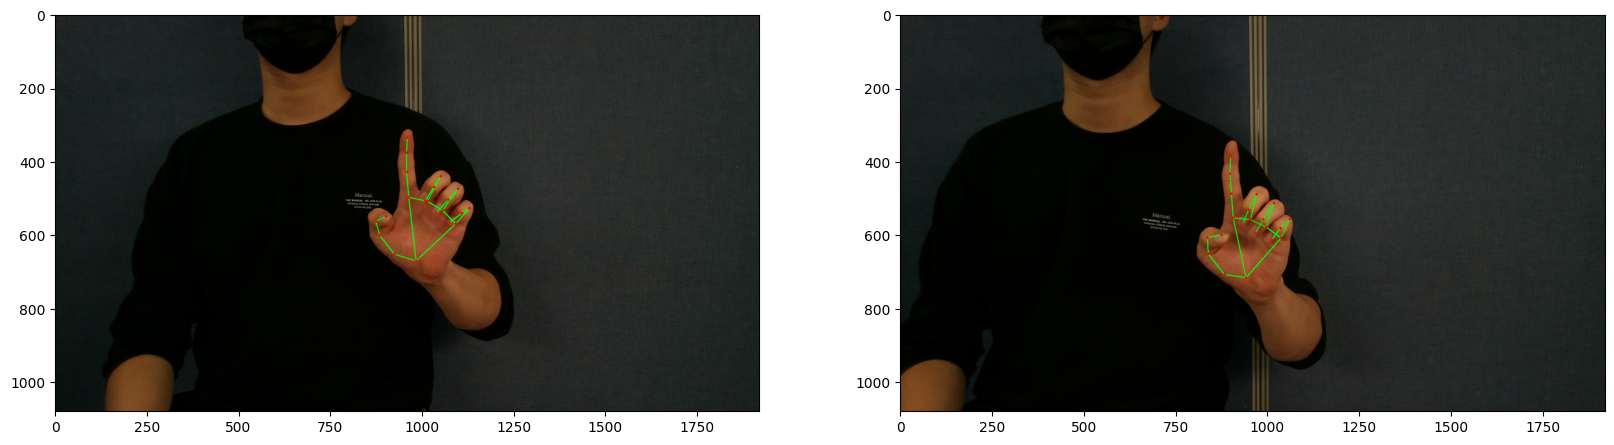

In [ ]:
path = f'./data/train/'
number1_folder = df[df['answer_name'] == '숫자1']['groups'].tolist()
shake_folder = df[df['answer_name'] == '부정(검지 흔들기)']['groups'].tolist()

image1 = Image.open(opj(path, number1_folder[0], '1.png'))   # 352번 폴더
image2 = Image.open(opj(path, shake_folder[11], '1.png'))    # 489번 폴더
print(number1_folder[0], shake_folder[11])

fig, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].imshow(image1)
ax[1].imshow(image2)
plt.show()


505 577


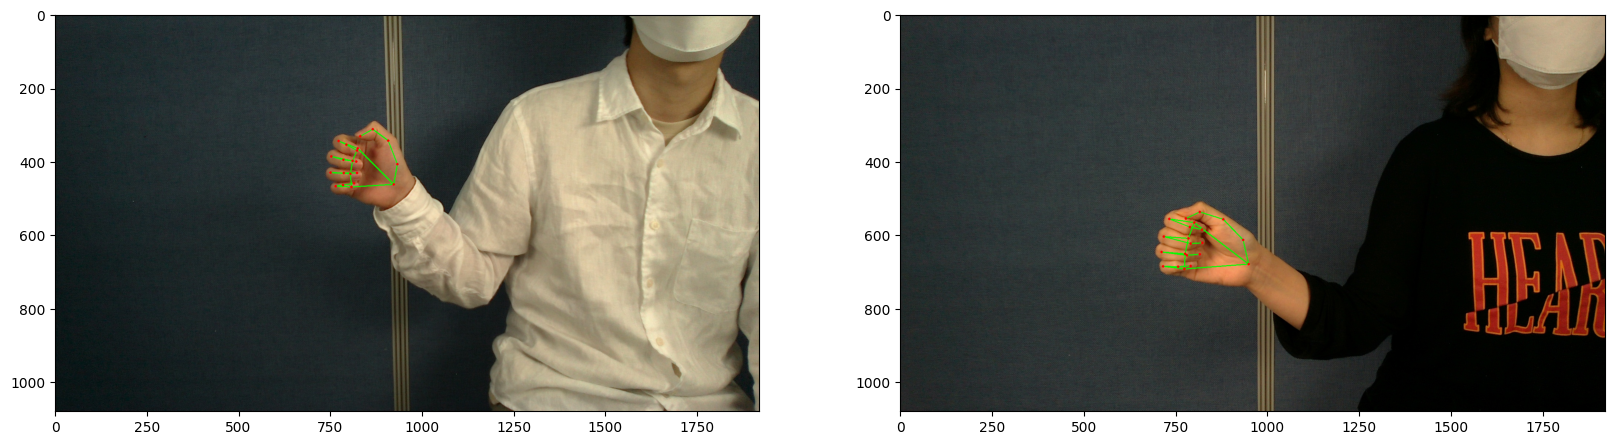

In [ ]:
path = f'./data/train/'
number1_folder = df[df['answer_name'] == '주먹쥐기']['groups'].tolist()
shake_folder = df[df['answer_name'] == '경고(주먹 내밀기)']['groups'].tolist()

image1 = Image.open(opj(path, number1_folder[1], '1.png'))   # 505번 폴더
image2 = Image.open(opj(path, shake_folder[9], '1.png'))    # 577번 폴더
print(number1_folder[1], shake_folder[9])

fig, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].imshow(image1)
ax[1].imshow(image2)
plt.show()

In [ ]:
def check_stats(find_list, ver):
    train_path = './data/train'
    train_folders = natsorted(glob(train_path + '/*'))
    stat_list = []
    for _, train_folder in tqdm(enumerate(train_folders)):
        try:
            json_path = glob(train_folder + '/*.json')[0]
            js = json.load(open(json_path))
            cat = js.get('action')[0]
            keypoints = js['annotations']
            keypoints = np.array([point['data'] for point in keypoints])  # (N-이미지개수, 21 or 42(keypoints), 3(x,y,z 좌표))
        except:
            pass
            # print(train_folder)
        if cat in find_list:
            # 숫자1과 검지흔들기 구분 # Case1
            # 검지는 이미지내 keypoints들 중 가장 작은 y값(이미지 상 가장 높은 위치)을 갖는 point임.
            # 해당 point의 x값을 뽑음.
            if ver ==1 :
                keypoints = keypoints[:, :, :2]  # keypoints : (N, 21 or 42, 2)
                x_I_finger = [point_per_img[:,0][point_per_img[:,1].argmin()] for point_per_img in keypoints] # (N, 2) Y축으로 가장 작은 포인트 두개 추출
                stat_list.append(np.max(x_I_finger) - np.min(x_I_finger))

            # 주먹쥐기와 주먹 내밀기(경고) # Case2
            # keypoints들 중 가장 큰 x값(이미지 상 가장 우측 위치)을 갖는 point임.
            # Case2같은 경우는 left손목이 없기때문에 해당 logic이 잘 작동함.
            elif ver == 2:
                keypoints = keypoints[:, :, 0]
                x_values = [point_per_img[point_per_img.argmax()] for point_per_img in keypoints]  # 가장 오른쪽
                stat_list.append(np.max(x_values) - np.min(x_values))

    print(stat_list)
    return stat_list

##label##
############ ver1 ###############
find_list0 = [0, 10, 100, 110] # ['숫자 1', '숫자1']  my hand, your hand 좌우
find_list1= [42, 67, 142, 167] # ['부정(검지 흔들기)'] my hand, your hand 좌우

############ ver2 ###############
find_list2 = [146] # ['주먹쥐기']  Your hand 우
find_list3 = [163] # ['경고(주먹 내밀기)'] Your hand 우

find_list4 = [171] # ['주먹쥐기']  Your hand Both
find_list5 = [191] # ['경고(주먹 내밀기)'] Your hand Both

In [ ]:
li0 = check_stats(find_list0,1)  #숫자1 or 숫자 1
li1 = check_stats(find_list1,1)  #부정(검지 흔들기)
threshold_ver1 = max(li0) + 5    # Margin 5
print(f'\n{threshold_ver1:.3f}보다 크면 부정(검지 흔들기) 클래스')

654it [00:00, 1947.26it/s]


[8.119010925292969, 6.710529327392578, 10.130081176757812, 25.8563232421875, 13.067092895507812, 6.2530517578125, 26.8505859375, 6.2162017822265625, 5.463695526123047, 11.729393005371094, 11.357345581054688, 3.2952117919921875, 2.7133941650390625]


654it [00:00, 2100.59it/s]

[205.29773712158203, 202.2853660583496, 181.16334915161133, 193.3260726928711, 146.09790802001953, 219.83436584472656, 201.2340545654297, 162.94750213623047, 149.35192108154297, 171.31982803344727, 128.1661605834961, 97.09001541137695, 20.372543334960938, 151.41706466674805, 151.18257522583008, 134.03549194335938, 53.82728576660156, 124.27928924560547, 9.581222534179688, 124.74632263183594]

31.851보다 크면 부정(검지 흔들기) 클래스


In [ ]:
li2 = check_stats(find_list2,2)
li3 = check_stats(find_list3,2)
threshold_ver2 = max(li2) + 5       # Margin 5
print(f'\n{threshold_ver2:.3f}보다 크면 주먹 내밀기(right) 클래스')

# 주먹쥐기 vs 주먹 내밀기 Both
li4 = check_stats(find_list4,2)
li4 = li4[1:]                       # 596번 폴더 변화량(218.313) Outlier -> 제외
li5 = check_stats(find_list5,2)
threshold_ver2_both = max(li4) + 5  # Margin 5
print(f'\n{threshold_ver2_both:.3f}보다 크면 주먹 내밀기(both) 클래스')

### Case2에서 Both와 Right를 구분하여 threshold를 구하고자 했지만 큰 차이가 없어서 실제 inference시에는 통합함. ###

654it [00:00, 1905.35it/s]


[7.338523864746094, 7.1413421630859375, 24.80083465576172, 8.968505859375]


654it [00:00, 2094.67it/s]


[52.795257568359375, 201.94839477539062, 34.79106903076172, 55.388145446777344, 36.262779235839844]

29.801보다 크면 주먹 내밀기(right) 클래스


654it [00:00, 2073.90it/s]


[218.31310272216797, 6.470375061035156, 29.33704376220703]


654it [00:00, 2041.15it/s]

[286.4274215698242, 337.5590515136719, 103.0282974243164]

34.337보다 크면 주먹 내밀기(both) 클래스


In [ ]:
def main(args):
    # Random Seed
    seed = args.seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True

    save_path = os.path.join(args.model_path, (args.exp_num).zfill(3))
    # Create model directory
    os.makedirs(save_path, exist_ok=True)
    Trainer(args, save_path)

In [ ]:
if __name__ == '__main__':
    for i in range(5):  # 5Folds Training
        args.fold = i
        args.exp_num = str(i)
        main(args)

Mapping dataframe Length (53, 5)
Use Flip Augmentation
Dataset size:4828
Dataset size:1207


100%|██████████| 302/302 [01:36<00:00,  3.14it/s]


 Epoch:[001/060]
Train Loss:5.112 | Acc:0.0035


Valid Loss:5.093 | Acc:0.0058


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[002/060]
Train Loss:5.113 | Acc:0.0046


Valid Loss:5.092 | Acc:0.0058


100%|██████████| 302/302 [01:36<00:00,  3.14it/s]


 Epoch:[003/060]
Train Loss:5.103 | Acc:0.0043


Valid Loss:5.086 | Acc:0.0058


100%|██████████| 302/302 [01:36<00:00,  3.13it/s]


 Epoch:[004/060]
Train Loss:5.095 | Acc:0.0058


Valid Loss:5.083 | Acc:0.0033


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[005/060]
Train Loss:5.090 | Acc:0.0075


Valid Loss:5.067 | Acc:0.0083


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[006/060]
Train Loss:5.047 | Acc:0.0068


Valid Loss:4.990 | Acc:0.0199


100%|██████████| 302/302 [01:36<00:00,  3.13it/s]


 Epoch:[007/060]
Train Loss:4.948 | Acc:0.0263


Valid Loss:4.846 | Acc:0.0547


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[008/060]
Train Loss:4.735 | Acc:0.0773


Valid Loss:4.472 | Acc:0.1566


100%|██████████| 302/302 [01:36<00:00,  3.13it/s]


 Epoch:[009/060]
Train Loss:4.222 | Acc:0.1870


Valid Loss:3.686 | Acc:0.2933


100%|██████████| 302/302 [01:37<00:00,  3.09it/s]


 Epoch:[010/060]
Train Loss:3.405 | Acc:0.2904


Valid Loss:2.514 | Acc:0.5037


100%|██████████| 302/302 [01:36<00:00,  3.15it/s]


 Epoch:[011/060]
Train Loss:2.502 | Acc:0.4497


Valid Loss:1.559 | Acc:0.6545


100%|██████████| 302/302 [01:37<00:00,  3.11it/s]


 Epoch:[012/060]
Train Loss:1.735 | Acc:0.6002


Valid Loss:0.889 | Acc:0.8169


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[013/060]
Train Loss:1.159 | Acc:0.7316


Valid Loss:0.475 | Acc:0.8890


100%|██████████| 302/302 [01:36<00:00,  3.14it/s]


 Epoch:[014/060]
Train Loss:0.797 | Acc:0.8217


Valid Loss:0.281 | Acc:0.9287


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[015/060]
Train Loss:0.562 | Acc:0.8720


Valid Loss:0.188 | Acc:0.9619


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[016/060]
Train Loss:0.433 | Acc:0.8952


Valid Loss:0.138 | Acc:0.9561


100%|██████████| 302/302 [01:37<00:00,  3.11it/s]


 Epoch:[017/060]
Train Loss:0.367 | Acc:0.9132


Valid Loss:0.123 | Acc:0.9635


100%|██████████| 302/302 [01:37<00:00,  3.09it/s]


 Epoch:[018/060]
Train Loss:0.306 | Acc:0.9217


Valid Loss:0.073 | Acc:0.9743


100%|██████████| 302/302 [01:36<00:00,  3.11it/s]


 Epoch:[019/060]
Train Loss:0.264 | Acc:0.9319


Valid Loss:0.098 | Acc:0.9669


100%|██████████| 302/302 [01:37<00:00,  3.11it/s]


 Epoch:[020/060]
Train Loss:0.246 | Acc:0.9360


Valid Loss:0.084 | Acc:0.9727


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[021/060]
Train Loss:0.210 | Acc:0.9430


Valid Loss:0.062 | Acc:0.9768


100%|██████████| 302/302 [01:37<00:00,  3.11it/s]


 Epoch:[022/060]
Train Loss:0.185 | Acc:0.9515


Valid Loss:0.074 | Acc:0.9760


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[023/060]
Train Loss:0.180 | Acc:0.9495


Valid Loss:0.045 | Acc:0.9826


100%|██████████| 302/302 [01:36<00:00,  3.13it/s]


 Epoch:[024/060]
Train Loss:0.170 | Acc:0.9536


Valid Loss:0.079 | Acc:0.9677


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[025/060]
Train Loss:0.157 | Acc:0.9565


Valid Loss:0.059 | Acc:0.9735


100%|██████████| 302/302 [01:36<00:00,  3.14it/s]


 Epoch:[026/060]
Train Loss:0.141 | Acc:0.9606


Valid Loss:0.053 | Acc:0.9809


100%|██████████| 302/302 [01:37<00:00,  3.11it/s]


 Epoch:[027/060]
Train Loss:0.141 | Acc:0.9571


Valid Loss:0.046 | Acc:0.9793


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[028/060]
Train Loss:0.112 | Acc:0.9640


Valid Loss:0.031 | Acc:0.9834


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[029/060]
Train Loss:0.126 | Acc:0.9631


Valid Loss:0.043 | Acc:0.9818


100%|██████████| 302/302 [01:36<00:00,  3.13it/s]


 Epoch:[030/060]
Train Loss:0.107 | Acc:0.9664


Valid Loss:0.032 | Acc:0.9834


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[031/060]
Train Loss:0.113 | Acc:0.9673


Valid Loss:0.103 | Acc:0.9768


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[032/060]
Train Loss:0.104 | Acc:0.9698


Valid Loss:0.054 | Acc:0.9760


100%|██████████| 302/302 [01:36<00:00,  3.13it/s]


 Epoch:[033/060]
Train Loss:0.088 | Acc:0.9722


Valid Loss:0.028 | Acc:0.9859


100%|██████████| 302/302 [01:36<00:00,  3.13it/s]


 Epoch:[034/060]
Train Loss:0.081 | Acc:0.9735


Valid Loss:0.031 | Acc:0.9859


100%|██████████| 302/302 [01:37<00:00,  3.11it/s]


 Epoch:[035/060]
Train Loss:0.078 | Acc:0.9756


Valid Loss:0.027 | Acc:0.9859


100%|██████████| 302/302 [01:37<00:00,  3.11it/s]


 Epoch:[036/060]
Train Loss:0.082 | Acc:0.9727


Valid Loss:0.030 | Acc:0.9876


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[037/060]
Train Loss:0.076 | Acc:0.9764


Valid Loss:0.032 | Acc:0.9843


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[038/060]
Train Loss:0.073 | Acc:0.9768


Valid Loss:0.025 | Acc:0.9867


100%|██████████| 302/302 [01:37<00:00,  3.11it/s]


 Epoch:[039/060]
Train Loss:0.065 | Acc:0.9774


Valid Loss:0.037 | Acc:0.9851


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[040/060]
Train Loss:0.066 | Acc:0.9772


Valid Loss:0.036 | Acc:0.9826


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[041/060]
Train Loss:0.060 | Acc:0.9785


Valid Loss:0.026 | Acc:0.9884


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[042/060]
Train Loss:0.053 | Acc:0.9814


Valid Loss:0.029 | Acc:0.9843


100%|██████████| 302/302 [01:37<00:00,  3.09it/s]


 Epoch:[043/060]
Train Loss:0.054 | Acc:0.9778


Valid Loss:0.026 | Acc:0.9876


100%|██████████| 302/302 [01:36<00:00,  3.13it/s]


 Epoch:[044/060]
Train Loss:0.044 | Acc:0.9818


Valid Loss:0.026 | Acc:0.9884


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[045/060]
Train Loss:0.048 | Acc:0.9822


Valid Loss:0.024 | Acc:0.9876


100%|██████████| 302/302 [01:36<00:00,  3.14it/s]


 Epoch:[046/060]
Train Loss:0.049 | Acc:0.9814


Valid Loss:0.030 | Acc:0.9843


100%|██████████| 302/302 [01:36<00:00,  3.13it/s]


 Epoch:[047/060]
Train Loss:0.039 | Acc:0.9822


Valid Loss:0.026 | Acc:0.9884


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[048/060]
Train Loss:0.041 | Acc:0.9832


Valid Loss:0.023 | Acc:0.9876


100%|██████████| 302/302 [01:36<00:00,  3.14it/s]


 Epoch:[049/060]
Train Loss:0.039 | Acc:0.9834


Valid Loss:0.021 | Acc:0.9859


100%|██████████| 302/302 [01:37<00:00,  3.11it/s]


 Epoch:[050/060]
Train Loss:0.037 | Acc:0.9836


Valid Loss:0.029 | Acc:0.9884


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[051/060]
Train Loss:0.037 | Acc:0.9841


Valid Loss:0.026 | Acc:0.9876


100%|██████████| 302/302 [01:37<00:00,  3.11it/s]


 Epoch:[052/060]
Train Loss:0.032 | Acc:0.9872


Valid Loss:0.023 | Acc:0.9867


100%|██████████| 302/302 [01:37<00:00,  3.09it/s]


 Epoch:[053/060]
Train Loss:0.029 | Acc:0.9872


Valid Loss:0.025 | Acc:0.9851


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[054/060]
Train Loss:0.031 | Acc:0.9884


Valid Loss:0.027 | Acc:0.9851


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[055/060]
Train Loss:0.029 | Acc:0.9880


Valid Loss:0.023 | Acc:0.9867


100%|██████████| 302/302 [01:37<00:00,  3.11it/s]


 Epoch:[056/060]
Train Loss:0.024 | Acc:0.9886


Valid Loss:0.028 | Acc:0.9867


100%|██████████| 302/302 [01:37<00:00,  3.11it/s]


 Epoch:[057/060]
Train Loss:0.025 | Acc:0.9892


Valid Loss:0.043 | Acc:0.9843


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[058/060]
Train Loss:0.026 | Acc:0.9892


Valid Loss:0.033 | Acc:0.9843


100%|██████████| 302/302 [01:36<00:00,  3.13it/s]


 Epoch:[059/060]
Train Loss:0.023 | Acc:0.9892


Valid Loss:0.028 | Acc:0.9859


100%|██████████| 302/302 [01:37<00:00,  3.09it/s]


 Epoch:[060/060]
Train Loss:0.023 | Acc:0.9888


Valid Loss:0.027 | Acc:0.9859

Best Val Epoch:49 | Val Loss:0.0211 | Val Acc:0.9859
Mapping dataframe Length (53, 5)
Use Flip Augmentation
Dataset size:4828
Dataset size:1207


100%|██████████| 302/302 [01:35<00:00,  3.15it/s]


 Epoch:[001/060]
Train Loss:5.108 | Acc:0.0048


Valid Loss:5.094 | Acc:0.0041


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[002/060]
Train Loss:5.107 | Acc:0.0043


Valid Loss:5.094 | Acc:0.0075


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[003/060]
Train Loss:5.108 | Acc:0.0029


Valid Loss:5.085 | Acc:0.0133


100%|██████████| 302/302 [01:36<00:00,  3.13it/s]


 Epoch:[004/060]
Train Loss:5.098 | Acc:0.0058


Valid Loss:5.081 | Acc:0.0108


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[005/060]
Train Loss:5.089 | Acc:0.0054


Valid Loss:5.073 | Acc:0.0099


100%|██████████| 302/302 [01:36<00:00,  3.14it/s]


 Epoch:[006/060]
Train Loss:5.049 | Acc:0.0058


Valid Loss:5.001 | Acc:0.0116


100%|██████████| 302/302 [01:35<00:00,  3.15it/s]


 Epoch:[007/060]
Train Loss:4.960 | Acc:0.0232


Valid Loss:4.875 | Acc:0.0472


100%|██████████| 302/302 [01:36<00:00,  3.13it/s]


 Epoch:[008/060]
Train Loss:4.783 | Acc:0.0661


Valid Loss:4.576 | Acc:0.1168


100%|██████████| 302/302 [01:36<00:00,  3.14it/s]


 Epoch:[009/060]
Train Loss:4.328 | Acc:0.1568


Valid Loss:3.767 | Acc:0.2916


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[010/060]
Train Loss:3.522 | Acc:0.2670


Valid Loss:2.688 | Acc:0.4300


100%|██████████| 302/302 [01:35<00:00,  3.16it/s]


 Epoch:[011/060]
Train Loss:2.602 | Acc:0.4207


Valid Loss:1.717 | Acc:0.5617


100%|██████████| 302/302 [01:35<00:00,  3.15it/s]


 Epoch:[012/060]
Train Loss:1.829 | Acc:0.5760


Valid Loss:0.981 | Acc:0.8020


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[013/060]
Train Loss:1.253 | Acc:0.7117


Valid Loss:0.569 | Acc:0.8674


100%|██████████| 302/302 [01:36<00:00,  3.13it/s]


 Epoch:[014/060]
Train Loss:0.853 | Acc:0.8063


Valid Loss:0.296 | Acc:0.9370


100%|██████████| 302/302 [01:37<00:00,  3.11it/s]


 Epoch:[015/060]
Train Loss:0.602 | Acc:0.8658


Valid Loss:0.175 | Acc:0.9577


100%|██████████| 302/302 [01:36<00:00,  3.13it/s]


 Epoch:[016/060]
Train Loss:0.435 | Acc:0.9016


Valid Loss:0.155 | Acc:0.9519


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[017/060]
Train Loss:0.375 | Acc:0.9147


Valid Loss:0.087 | Acc:0.9710


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[018/060]
Train Loss:0.301 | Acc:0.9265


Valid Loss:0.077 | Acc:0.9693


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[019/060]
Train Loss:0.271 | Acc:0.9294


Valid Loss:0.119 | Acc:0.9611


100%|██████████| 302/302 [01:37<00:00,  3.09it/s]


 Epoch:[020/060]
Train Loss:0.257 | Acc:0.9319


Valid Loss:0.067 | Acc:0.9743


100%|██████████| 302/302 [01:36<00:00,  3.14it/s]


 Epoch:[021/060]
Train Loss:0.205 | Acc:0.9480


Valid Loss:0.069 | Acc:0.9743


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[022/060]
Train Loss:0.198 | Acc:0.9430


Valid Loss:0.059 | Acc:0.9743


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[023/060]
Train Loss:0.181 | Acc:0.9513


Valid Loss:0.058 | Acc:0.9768


100%|██████████| 302/302 [01:36<00:00,  3.13it/s]


 Epoch:[024/060]
Train Loss:0.174 | Acc:0.9515


Valid Loss:0.057 | Acc:0.9801


100%|██████████| 302/302 [01:37<00:00,  3.11it/s]


 Epoch:[025/060]
Train Loss:0.160 | Acc:0.9559


Valid Loss:0.052 | Acc:0.9818


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[026/060]
Train Loss:0.151 | Acc:0.9573


Valid Loss:0.035 | Acc:0.9867


100%|██████████| 302/302 [01:35<00:00,  3.15it/s]


 Epoch:[027/060]
Train Loss:0.143 | Acc:0.9588


Valid Loss:0.075 | Acc:0.9693


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[028/060]
Train Loss:0.118 | Acc:0.9664


Valid Loss:0.066 | Acc:0.9760


100%|██████████| 302/302 [01:36<00:00,  3.13it/s]


 Epoch:[029/060]
Train Loss:0.121 | Acc:0.9662


Valid Loss:0.053 | Acc:0.9826


100%|██████████| 302/302 [01:35<00:00,  3.15it/s]


 Epoch:[030/060]
Train Loss:0.111 | Acc:0.9656


Valid Loss:0.059 | Acc:0.9768


100%|██████████| 302/302 [01:36<00:00,  3.13it/s]


 Epoch:[031/060]
Train Loss:0.104 | Acc:0.9650


Valid Loss:0.046 | Acc:0.9818


100%|██████████| 302/302 [01:36<00:00,  3.13it/s]


 Epoch:[032/060]
Train Loss:0.105 | Acc:0.9667


Valid Loss:0.036 | Acc:0.9859


100%|██████████| 302/302 [01:36<00:00,  3.14it/s]


 Epoch:[033/060]
Train Loss:0.093 | Acc:0.9722


Valid Loss:0.156 | Acc:0.9669


100%|██████████| 302/302 [01:36<00:00,  3.13it/s]


 Epoch:[034/060]
Train Loss:0.095 | Acc:0.9706


Valid Loss:0.036 | Acc:0.9826


100%|██████████| 302/302 [01:37<00:00,  3.11it/s]


 Epoch:[035/060]
Train Loss:0.092 | Acc:0.9727


Valid Loss:0.026 | Acc:0.9843


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[036/060]
Train Loss:0.080 | Acc:0.9747


Valid Loss:0.032 | Acc:0.9867


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[037/060]
Train Loss:0.073 | Acc:0.9768


Valid Loss:0.024 | Acc:0.9859


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[038/060]
Train Loss:0.070 | Acc:0.9768


Valid Loss:0.033 | Acc:0.9834


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[039/060]
Train Loss:0.063 | Acc:0.9783


Valid Loss:0.050 | Acc:0.9843


100%|██████████| 302/302 [01:36<00:00,  3.13it/s]


 Epoch:[040/060]
Train Loss:0.060 | Acc:0.9760


Valid Loss:0.033 | Acc:0.9818


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[041/060]
Train Loss:0.065 | Acc:0.9803


Valid Loss:0.027 | Acc:0.9892


100%|██████████| 302/302 [01:37<00:00,  3.08it/s]


 Epoch:[042/060]
Train Loss:0.052 | Acc:0.9801


Valid Loss:0.031 | Acc:0.9843


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[043/060]
Train Loss:0.049 | Acc:0.9814


Valid Loss:0.038 | Acc:0.9834


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[044/060]
Train Loss:0.048 | Acc:0.9816


Valid Loss:0.061 | Acc:0.9751


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[045/060]
Train Loss:0.049 | Acc:0.9812


Valid Loss:0.023 | Acc:0.9851


100%|██████████| 302/302 [01:36<00:00,  3.14it/s]


 Epoch:[046/060]
Train Loss:0.045 | Acc:0.9832


Valid Loss:0.022 | Acc:0.9892


100%|██████████| 302/302 [01:36<00:00,  3.13it/s]


 Epoch:[047/060]
Train Loss:0.043 | Acc:0.9824


Valid Loss:0.020 | Acc:0.9901


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[048/060]
Train Loss:0.039 | Acc:0.9853


Valid Loss:0.033 | Acc:0.9818


100%|██████████| 302/302 [01:37<00:00,  3.11it/s]


 Epoch:[049/060]
Train Loss:0.037 | Acc:0.9838


Valid Loss:0.040 | Acc:0.9859


100%|██████████| 302/302 [01:36<00:00,  3.13it/s]


 Epoch:[050/060]
Train Loss:0.042 | Acc:0.9834


Valid Loss:0.019 | Acc:0.9901


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[051/060]
Train Loss:0.026 | Acc:0.9882


Valid Loss:0.021 | Acc:0.9892


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[052/060]
Train Loss:0.031 | Acc:0.9870


Valid Loss:0.038 | Acc:0.9834


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[053/060]
Train Loss:0.032 | Acc:0.9843


Valid Loss:0.019 | Acc:0.9892


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[054/060]
Train Loss:0.028 | Acc:0.9859


Valid Loss:0.019 | Acc:0.9867


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[055/060]
Train Loss:0.028 | Acc:0.9872


Valid Loss:0.021 | Acc:0.9892


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[056/060]
Train Loss:0.026 | Acc:0.9865


Valid Loss:0.019 | Acc:0.9884


100%|██████████| 302/302 [01:37<00:00,  3.09it/s]


 Epoch:[057/060]
Train Loss:0.026 | Acc:0.9880


Valid Loss:0.019 | Acc:0.9867


100%|██████████| 302/302 [01:37<00:00,  3.09it/s]


 Epoch:[058/060]
Train Loss:0.027 | Acc:0.9890


Valid Loss:0.021 | Acc:0.9859


100%|██████████| 302/302 [01:37<00:00,  3.11it/s]


 Epoch:[059/060]
Train Loss:0.022 | Acc:0.9882


Valid Loss:0.023 | Acc:0.9876


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[060/060]
Train Loss:0.023 | Acc:0.9874


Valid Loss:0.019 | Acc:0.9876

Best Val Epoch:50 | Val Loss:0.0186 | Val Acc:0.9901
Mapping dataframe Length (53, 5)
Use Flip Augmentation
Dataset size:4828
Dataset size:1207


100%|██████████| 302/302 [01:37<00:00,  3.11it/s]


 Epoch:[001/060]
Train Loss:5.108 | Acc:0.0021


Valid Loss:5.092 | Acc:0.0066


100%|██████████| 302/302 [01:37<00:00,  3.11it/s]


 Epoch:[002/060]
Train Loss:5.110 | Acc:0.0043


Valid Loss:5.095 | Acc:0.0058


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[003/060]
Train Loss:5.101 | Acc:0.0046


Valid Loss:5.087 | Acc:0.0066


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[004/060]
Train Loss:5.094 | Acc:0.0058


Valid Loss:5.081 | Acc:0.0041


100%|██████████| 302/302 [01:36<00:00,  3.13it/s]


 Epoch:[005/060]
Train Loss:5.091 | Acc:0.0048


Valid Loss:5.071 | Acc:0.0083


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[006/060]
Train Loss:5.042 | Acc:0.0120


Valid Loss:4.983 | Acc:0.0199


100%|██████████| 302/302 [01:36<00:00,  3.11it/s]


 Epoch:[007/060]
Train Loss:4.945 | Acc:0.0240


Valid Loss:4.836 | Acc:0.0522


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[008/060]
Train Loss:4.725 | Acc:0.0793


Valid Loss:4.451 | Acc:0.1723


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[009/060]
Train Loss:4.224 | Acc:0.1734


Valid Loss:3.643 | Acc:0.2966


100%|██████████| 302/302 [01:37<00:00,  3.09it/s]


 Epoch:[010/060]
Train Loss:3.391 | Acc:0.2954


Valid Loss:2.496 | Acc:0.4540


100%|██████████| 302/302 [01:37<00:00,  3.11it/s]


 Epoch:[011/060]
Train Loss:2.493 | Acc:0.4474


Valid Loss:1.549 | Acc:0.6346


100%|██████████| 302/302 [01:37<00:00,  3.09it/s]


 Epoch:[012/060]
Train Loss:1.725 | Acc:0.6162


Valid Loss:0.916 | Acc:0.7746


100%|██████████| 302/302 [01:37<00:00,  3.11it/s]


 Epoch:[013/060]
Train Loss:1.153 | Acc:0.7345


Valid Loss:0.499 | Acc:0.8815


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[014/060]
Train Loss:0.772 | Acc:0.8302


Valid Loss:0.274 | Acc:0.9379


100%|██████████| 302/302 [01:36<00:00,  3.13it/s]


 Epoch:[015/060]
Train Loss:0.560 | Acc:0.8730


Valid Loss:0.170 | Acc:0.9627


100%|██████████| 302/302 [01:37<00:00,  3.09it/s]


 Epoch:[016/060]
Train Loss:0.423 | Acc:0.9024


Valid Loss:0.141 | Acc:0.9561


100%|██████████| 302/302 [01:37<00:00,  3.09it/s]


 Epoch:[017/060]
Train Loss:0.374 | Acc:0.9037


Valid Loss:0.112 | Acc:0.9652


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[018/060]
Train Loss:0.291 | Acc:0.9250


Valid Loss:0.102 | Acc:0.9644


100%|██████████| 302/302 [01:37<00:00,  3.11it/s]


 Epoch:[019/060]
Train Loss:0.274 | Acc:0.9273


Valid Loss:0.085 | Acc:0.9702


100%|██████████| 302/302 [01:37<00:00,  3.09it/s]


 Epoch:[020/060]
Train Loss:0.233 | Acc:0.9399


Valid Loss:0.094 | Acc:0.9710


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[021/060]
Train Loss:0.210 | Acc:0.9410


Valid Loss:0.107 | Acc:0.9644


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[022/060]
Train Loss:0.194 | Acc:0.9490


Valid Loss:0.069 | Acc:0.9735


100%|██████████| 302/302 [01:37<00:00,  3.09it/s]


 Epoch:[023/060]
Train Loss:0.183 | Acc:0.9486


Valid Loss:0.079 | Acc:0.9718


100%|██████████| 302/302 [01:37<00:00,  3.11it/s]


 Epoch:[024/060]
Train Loss:0.166 | Acc:0.9538


Valid Loss:0.054 | Acc:0.9851


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[025/060]
Train Loss:0.150 | Acc:0.9577


Valid Loss:0.074 | Acc:0.9751


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[026/060]
Train Loss:0.131 | Acc:0.9625


Valid Loss:0.066 | Acc:0.9768


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[027/060]
Train Loss:0.128 | Acc:0.9623


Valid Loss:0.079 | Acc:0.9669


100%|██████████| 302/302 [01:37<00:00,  3.09it/s]


 Epoch:[028/060]
Train Loss:0.130 | Acc:0.9602


Valid Loss:0.063 | Acc:0.9718


100%|██████████| 302/302 [01:37<00:00,  3.11it/s]


 Epoch:[029/060]
Train Loss:0.118 | Acc:0.9644


Valid Loss:0.068 | Acc:0.9776


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[030/060]
Train Loss:0.112 | Acc:0.9642


Valid Loss:0.046 | Acc:0.9818


100%|██████████| 302/302 [01:38<00:00,  3.06it/s]


 Epoch:[031/060]
Train Loss:0.101 | Acc:0.9664


Valid Loss:0.052 | Acc:0.9793


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[032/060]
Train Loss:0.098 | Acc:0.9693


Valid Loss:0.049 | Acc:0.9826


100%|██████████| 302/302 [01:36<00:00,  3.13it/s]


 Epoch:[033/060]
Train Loss:0.088 | Acc:0.9714


Valid Loss:0.068 | Acc:0.9776


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[034/060]
Train Loss:0.093 | Acc:0.9731


Valid Loss:0.070 | Acc:0.9743


100%|██████████| 302/302 [01:36<00:00,  3.11it/s]


 Epoch:[035/060]
Train Loss:0.081 | Acc:0.9764


Valid Loss:0.059 | Acc:0.9768


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[036/060]
Train Loss:0.081 | Acc:0.9749


Valid Loss:0.044 | Acc:0.9851


100%|██████████| 302/302 [01:37<00:00,  3.09it/s]


 Epoch:[037/060]
Train Loss:0.074 | Acc:0.9778


Valid Loss:0.081 | Acc:0.9751


100%|██████████| 302/302 [01:36<00:00,  3.13it/s]


 Epoch:[038/060]
Train Loss:0.074 | Acc:0.9758


Valid Loss:0.039 | Acc:0.9867


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[039/060]
Train Loss:0.061 | Acc:0.9776


Valid Loss:0.036 | Acc:0.9851


100%|██████████| 302/302 [01:38<00:00,  3.08it/s]


 Epoch:[040/060]
Train Loss:0.075 | Acc:0.9741


Valid Loss:0.040 | Acc:0.9859


100%|██████████| 302/302 [01:37<00:00,  3.09it/s]


 Epoch:[041/060]
Train Loss:0.058 | Acc:0.9787


Valid Loss:0.052 | Acc:0.9859


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[042/060]
Train Loss:0.056 | Acc:0.9793


Valid Loss:0.047 | Acc:0.9859


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[043/060]
Train Loss:0.052 | Acc:0.9814


Valid Loss:0.045 | Acc:0.9851


100%|██████████| 302/302 [01:36<00:00,  3.11it/s]


 Epoch:[044/060]
Train Loss:0.053 | Acc:0.9809


Valid Loss:0.058 | Acc:0.9809


100%|██████████| 302/302 [01:37<00:00,  3.11it/s]


 Epoch:[045/060]
Train Loss:0.047 | Acc:0.9820


Valid Loss:0.044 | Acc:0.9809


100%|██████████| 302/302 [01:37<00:00,  3.11it/s]


 Epoch:[046/060]
Train Loss:0.049 | Acc:0.9812


Valid Loss:0.040 | Acc:0.9867


100%|██████████| 302/302 [01:37<00:00,  3.09it/s]


 Epoch:[047/060]
Train Loss:0.044 | Acc:0.9830


Valid Loss:0.039 | Acc:0.9859


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[048/060]
Train Loss:0.040 | Acc:0.9841


Valid Loss:0.049 | Acc:0.9867


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[049/060]
Train Loss:0.035 | Acc:0.9857


Valid Loss:0.048 | Acc:0.9851


100%|██████████| 302/302 [01:37<00:00,  3.11it/s]


 Epoch:[050/060]
Train Loss:0.033 | Acc:0.9872


Valid Loss:0.033 | Acc:0.9867


100%|██████████| 302/302 [01:37<00:00,  3.08it/s]


 Epoch:[051/060]
Train Loss:0.034 | Acc:0.9857


Valid Loss:0.046 | Acc:0.9859


100%|██████████| 302/302 [01:37<00:00,  3.11it/s]


 Epoch:[052/060]
Train Loss:0.026 | Acc:0.9870


Valid Loss:0.048 | Acc:0.9851


100%|██████████| 302/302 [01:38<00:00,  3.07it/s]


 Epoch:[053/060]
Train Loss:0.030 | Acc:0.9859


Valid Loss:0.038 | Acc:0.9876


100%|██████████| 302/302 [01:37<00:00,  3.11it/s]


 Epoch:[054/060]
Train Loss:0.031 | Acc:0.9870


Valid Loss:0.042 | Acc:0.9859


100%|██████████| 302/302 [01:36<00:00,  3.13it/s]


 Epoch:[055/060]
Train Loss:0.025 | Acc:0.9892


Valid Loss:0.041 | Acc:0.9867


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[056/060]
Train Loss:0.028 | Acc:0.9863


Valid Loss:0.039 | Acc:0.9876


100%|██████████| 302/302 [01:37<00:00,  3.11it/s]


 Epoch:[057/060]
Train Loss:0.024 | Acc:0.9872


Valid Loss:0.036 | Acc:0.9867


100%|██████████| 302/302 [01:36<00:00,  3.11it/s]


 Epoch:[058/060]
Train Loss:0.026 | Acc:0.9874


Valid Loss:0.029 | Acc:0.9884


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[059/060]
Train Loss:0.022 | Acc:0.9894


Valid Loss:0.036 | Acc:0.9867


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[060/060]
Train Loss:0.021 | Acc:0.9882


Valid Loss:0.036 | Acc:0.9851

Best Val Epoch:58 | Val Loss:0.0293 | Val Acc:0.9884
Mapping dataframe Length (53, 5)
Use Flip Augmentation
Dataset size:4828
Dataset size:1207


100%|██████████| 302/302 [01:36<00:00,  3.13it/s]


 Epoch:[001/060]
Train Loss:5.110 | Acc:0.0043


Valid Loss:5.094 | Acc:0.0099


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[002/060]
Train Loss:5.111 | Acc:0.0048


Valid Loss:5.094 | Acc:0.0041


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[003/060]
Train Loss:5.104 | Acc:0.0033


Valid Loss:5.084 | Acc:0.0083


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[004/060]
Train Loss:5.100 | Acc:0.0037


Valid Loss:5.081 | Acc:0.0091


100%|██████████| 302/302 [01:36<00:00,  3.13it/s]


 Epoch:[005/060]
Train Loss:5.092 | Acc:0.0043


Valid Loss:5.069 | Acc:0.0058


100%|██████████| 302/302 [01:37<00:00,  3.11it/s]


 Epoch:[006/060]
Train Loss:5.047 | Acc:0.0093


Valid Loss:4.993 | Acc:0.0124


100%|██████████| 302/302 [01:37<00:00,  3.09it/s]


 Epoch:[007/060]
Train Loss:4.953 | Acc:0.0217


Valid Loss:4.849 | Acc:0.0580


100%|██████████| 302/302 [01:37<00:00,  3.11it/s]


 Epoch:[008/060]
Train Loss:4.746 | Acc:0.0818


Valid Loss:4.498 | Acc:0.1599


100%|██████████| 302/302 [01:37<00:00,  3.09it/s]


 Epoch:[009/060]
Train Loss:4.254 | Acc:0.1775


Valid Loss:3.734 | Acc:0.2949


100%|██████████| 302/302 [01:38<00:00,  3.07it/s]


 Epoch:[010/060]
Train Loss:3.444 | Acc:0.2867


Valid Loss:2.541 | Acc:0.4814


100%|██████████| 302/302 [01:37<00:00,  3.09it/s]


 Epoch:[011/060]
Train Loss:2.534 | Acc:0.4381


Valid Loss:1.596 | Acc:0.6156


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[012/060]
Train Loss:1.757 | Acc:0.5949


Valid Loss:0.946 | Acc:0.7746


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[013/060]
Train Loss:1.167 | Acc:0.7336


Valid Loss:0.516 | Acc:0.8906


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[014/060]
Train Loss:0.797 | Acc:0.8123


Valid Loss:0.269 | Acc:0.9478


100%|██████████| 302/302 [01:37<00:00,  3.11it/s]


 Epoch:[015/060]
Train Loss:0.564 | Acc:0.8679


Valid Loss:0.183 | Acc:0.9544


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[016/060]
Train Loss:0.439 | Acc:0.9002


Valid Loss:0.129 | Acc:0.9702


100%|██████████| 302/302 [01:37<00:00,  3.08it/s]


 Epoch:[017/060]
Train Loss:0.368 | Acc:0.9136


Valid Loss:0.107 | Acc:0.9685


100%|██████████| 302/302 [01:37<00:00,  3.09it/s]


 Epoch:[018/060]
Train Loss:0.300 | Acc:0.9215


Valid Loss:0.100 | Acc:0.9611


100%|██████████| 302/302 [01:37<00:00,  3.11it/s]


 Epoch:[019/060]
Train Loss:0.266 | Acc:0.9331


Valid Loss:0.090 | Acc:0.9660


100%|██████████| 302/302 [01:37<00:00,  3.09it/s]


 Epoch:[020/060]
Train Loss:0.239 | Acc:0.9360


Valid Loss:0.085 | Acc:0.9727


100%|██████████| 302/302 [01:36<00:00,  3.15it/s]


 Epoch:[021/060]
Train Loss:0.209 | Acc:0.9422


Valid Loss:0.079 | Acc:0.9735


100%|██████████| 302/302 [01:37<00:00,  3.11it/s]


 Epoch:[022/060]
Train Loss:0.196 | Acc:0.9461


Valid Loss:0.126 | Acc:0.9569


100%|██████████| 302/302 [01:37<00:00,  3.11it/s]


 Epoch:[023/060]
Train Loss:0.186 | Acc:0.9517


Valid Loss:0.080 | Acc:0.9727


100%|██████████| 302/302 [01:38<00:00,  3.08it/s]


 Epoch:[024/060]
Train Loss:0.177 | Acc:0.9515


Valid Loss:0.057 | Acc:0.9801


100%|██████████| 302/302 [01:38<00:00,  3.08it/s]


 Epoch:[025/060]
Train Loss:0.149 | Acc:0.9536


Valid Loss:0.096 | Acc:0.9693


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[026/060]
Train Loss:0.142 | Acc:0.9606


Valid Loss:0.099 | Acc:0.9635


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[027/060]
Train Loss:0.141 | Acc:0.9609


Valid Loss:0.067 | Acc:0.9760


100%|██████████| 302/302 [01:37<00:00,  3.08it/s]


 Epoch:[028/060]
Train Loss:0.125 | Acc:0.9644


Valid Loss:0.063 | Acc:0.9785


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[029/060]
Train Loss:0.114 | Acc:0.9652


Valid Loss:0.045 | Acc:0.9809


100%|██████████| 302/302 [01:37<00:00,  3.09it/s]


 Epoch:[030/060]
Train Loss:0.119 | Acc:0.9652


Valid Loss:0.108 | Acc:0.9693


100%|██████████| 302/302 [01:38<00:00,  3.07it/s]


 Epoch:[031/060]
Train Loss:0.098 | Acc:0.9683


Valid Loss:0.054 | Acc:0.9818


100%|██████████| 302/302 [01:38<00:00,  3.07it/s]


 Epoch:[032/060]
Train Loss:0.096 | Acc:0.9700


Valid Loss:0.122 | Acc:0.9743


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[033/060]
Train Loss:0.084 | Acc:0.9714


Valid Loss:0.070 | Acc:0.9735


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[034/060]
Train Loss:0.094 | Acc:0.9712


Valid Loss:0.047 | Acc:0.9843


100%|██████████| 302/302 [01:37<00:00,  3.09it/s]


 Epoch:[035/060]
Train Loss:0.081 | Acc:0.9743


Valid Loss:0.075 | Acc:0.9735


100%|██████████| 302/302 [01:37<00:00,  3.09it/s]


 Epoch:[036/060]
Train Loss:0.070 | Acc:0.9762


Valid Loss:0.044 | Acc:0.9801


100%|██████████| 302/302 [01:37<00:00,  3.08it/s]


 Epoch:[037/060]
Train Loss:0.079 | Acc:0.9725


Valid Loss:0.048 | Acc:0.9834


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[038/060]
Train Loss:0.074 | Acc:0.9774


Valid Loss:0.048 | Acc:0.9859


100%|██████████| 302/302 [01:38<00:00,  3.07it/s]


 Epoch:[039/060]
Train Loss:0.059 | Acc:0.9803


Valid Loss:0.046 | Acc:0.9834


100%|██████████| 302/302 [01:38<00:00,  3.08it/s]


 Epoch:[040/060]
Train Loss:0.061 | Acc:0.9787


Valid Loss:0.039 | Acc:0.9793


100%|██████████| 302/302 [01:37<00:00,  3.09it/s]


 Epoch:[041/060]
Train Loss:0.065 | Acc:0.9774


Valid Loss:0.051 | Acc:0.9793


100%|██████████| 302/302 [01:38<00:00,  3.08it/s]


 Epoch:[042/060]
Train Loss:0.050 | Acc:0.9824


Valid Loss:0.046 | Acc:0.9826


100%|██████████| 302/302 [01:37<00:00,  3.09it/s]


 Epoch:[043/060]
Train Loss:0.043 | Acc:0.9830


Valid Loss:0.049 | Acc:0.9843


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[044/060]
Train Loss:0.049 | Acc:0.9803


Valid Loss:0.070 | Acc:0.9818


100%|██████████| 302/302 [01:37<00:00,  3.09it/s]


 Epoch:[045/060]
Train Loss:0.048 | Acc:0.9820


Valid Loss:0.034 | Acc:0.9876


100%|██████████| 302/302 [01:37<00:00,  3.08it/s]


 Epoch:[046/060]
Train Loss:0.043 | Acc:0.9841


Valid Loss:0.030 | Acc:0.9859


100%|██████████| 302/302 [01:37<00:00,  3.09it/s]


 Epoch:[047/060]
Train Loss:0.037 | Acc:0.9838


Valid Loss:0.050 | Acc:0.9826


100%|██████████| 302/302 [01:37<00:00,  3.08it/s]


 Epoch:[048/060]
Train Loss:0.041 | Acc:0.9824


Valid Loss:0.039 | Acc:0.9826


100%|██████████| 302/302 [01:37<00:00,  3.09it/s]


 Epoch:[049/060]
Train Loss:0.034 | Acc:0.9841


Valid Loss:0.038 | Acc:0.9826


100%|██████████| 302/302 [01:37<00:00,  3.11it/s]


 Epoch:[050/060]
Train Loss:0.032 | Acc:0.9863


Valid Loss:0.041 | Acc:0.9876


100%|██████████| 302/302 [01:37<00:00,  3.11it/s]


 Epoch:[051/060]
Train Loss:0.032 | Acc:0.9861


Valid Loss:0.036 | Acc:0.9876


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[052/060]
Train Loss:0.032 | Acc:0.9851


Valid Loss:0.041 | Acc:0.9834


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[053/060]
Train Loss:0.029 | Acc:0.9861


Valid Loss:0.035 | Acc:0.9851


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[054/060]
Train Loss:0.023 | Acc:0.9880


Valid Loss:0.040 | Acc:0.9867


100%|██████████| 302/302 [01:37<00:00,  3.11it/s]


 Epoch:[055/060]
Train Loss:0.024 | Acc:0.9880


Valid Loss:0.033 | Acc:0.9851


100%|██████████| 302/302 [01:37<00:00,  3.11it/s]


 Epoch:[056/060]
Train Loss:0.026 | Acc:0.9863


Valid Loss:0.034 | Acc:0.9851


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[057/060]
Train Loss:0.023 | Acc:0.9880


Valid Loss:0.033 | Acc:0.9867


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[058/060]
Train Loss:0.024 | Acc:0.9882


Valid Loss:0.032 | Acc:0.9867


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[059/060]
Train Loss:0.021 | Acc:0.9888


Valid Loss:0.035 | Acc:0.9851


100%|██████████| 302/302 [01:37<00:00,  3.11it/s]


 Epoch:[060/060]
Train Loss:0.022 | Acc:0.9886


Valid Loss:0.034 | Acc:0.9867

Best Val Epoch:46 | Val Loss:0.0300 | Val Acc:0.9859
Mapping dataframe Length (53, 5)
Use Flip Augmentation
Dataset size:4828
Dataset size:1207


100%|██████████| 302/302 [01:36<00:00,  3.13it/s]


 Epoch:[001/060]
Train Loss:5.107 | Acc:0.0033


Valid Loss:5.094 | Acc:0.0066


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[002/060]
Train Loss:5.108 | Acc:0.0043


Valid Loss:5.091 | Acc:0.0066


100%|██████████| 302/302 [01:36<00:00,  3.13it/s]


 Epoch:[003/060]
Train Loss:5.104 | Acc:0.0052


Valid Loss:5.086 | Acc:0.0099


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[004/060]
Train Loss:5.093 | Acc:0.0056


Valid Loss:5.080 | Acc:0.0124


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[005/060]
Train Loss:5.091 | Acc:0.0046


Valid Loss:5.069 | Acc:0.0075


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[006/060]
Train Loss:5.044 | Acc:0.0089


Valid Loss:4.988 | Acc:0.0108


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[007/060]
Train Loss:4.952 | Acc:0.0240


Valid Loss:4.846 | Acc:0.0497


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[008/060]
Train Loss:4.739 | Acc:0.0808


Valid Loss:4.476 | Acc:0.1682


100%|██████████| 302/302 [01:37<00:00,  3.11it/s]


 Epoch:[009/060]
Train Loss:4.236 | Acc:0.1717


Valid Loss:3.636 | Acc:0.3273


100%|██████████| 302/302 [01:37<00:00,  3.09it/s]


 Epoch:[010/060]
Train Loss:3.406 | Acc:0.2935


Valid Loss:2.529 | Acc:0.4780


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[011/060]
Train Loss:2.502 | Acc:0.4364


Valid Loss:1.557 | Acc:0.6313


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[012/060]
Train Loss:1.744 | Acc:0.5812


Valid Loss:0.945 | Acc:0.7804


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[013/060]
Train Loss:1.168 | Acc:0.7287


Valid Loss:0.522 | Acc:0.8757


100%|██████████| 302/302 [01:37<00:00,  3.11it/s]


 Epoch:[014/060]
Train Loss:0.808 | Acc:0.8097


Valid Loss:0.302 | Acc:0.9296


100%|██████████| 302/302 [01:36<00:00,  3.13it/s]


 Epoch:[015/060]
Train Loss:0.586 | Acc:0.8654


Valid Loss:0.179 | Acc:0.9635


100%|██████████| 302/302 [01:38<00:00,  3.08it/s]


 Epoch:[016/060]
Train Loss:0.436 | Acc:0.9016


Valid Loss:0.154 | Acc:0.9611


100%|██████████| 302/302 [01:37<00:00,  3.11it/s]


 Epoch:[017/060]
Train Loss:0.382 | Acc:0.9076


Valid Loss:0.125 | Acc:0.9652


100%|██████████| 302/302 [01:37<00:00,  3.08it/s]


 Epoch:[018/060]
Train Loss:0.299 | Acc:0.9242


Valid Loss:0.088 | Acc:0.9768


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[019/060]
Train Loss:0.261 | Acc:0.9354


Valid Loss:0.136 | Acc:0.9536


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[020/060]
Train Loss:0.238 | Acc:0.9354


Valid Loss:0.083 | Acc:0.9710


100%|██████████| 302/302 [01:37<00:00,  3.11it/s]


 Epoch:[021/060]
Train Loss:0.220 | Acc:0.9408


Valid Loss:0.095 | Acc:0.9702


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[022/060]
Train Loss:0.194 | Acc:0.9478


Valid Loss:0.100 | Acc:0.9710


100%|██████████| 302/302 [01:36<00:00,  3.14it/s]


 Epoch:[023/060]
Train Loss:0.175 | Acc:0.9544


Valid Loss:0.098 | Acc:0.9693


100%|██████████| 302/302 [01:36<00:00,  3.13it/s]


 Epoch:[024/060]
Train Loss:0.166 | Acc:0.9548


Valid Loss:0.083 | Acc:0.9751


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[025/060]
Train Loss:0.165 | Acc:0.9538


Valid Loss:0.106 | Acc:0.9594


100%|██████████| 302/302 [01:37<00:00,  3.09it/s]


 Epoch:[026/060]
Train Loss:0.149 | Acc:0.9577


Valid Loss:0.083 | Acc:0.9735


100%|██████████| 302/302 [01:36<00:00,  3.14it/s]


 Epoch:[027/060]
Train Loss:0.130 | Acc:0.9617


Valid Loss:0.080 | Acc:0.9785


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[028/060]
Train Loss:0.120 | Acc:0.9644


Valid Loss:0.057 | Acc:0.9809


100%|██████████| 302/302 [01:36<00:00,  3.14it/s]


 Epoch:[029/060]
Train Loss:0.120 | Acc:0.9615


Valid Loss:0.089 | Acc:0.9718


100%|██████████| 302/302 [01:36<00:00,  3.13it/s]


 Epoch:[030/060]
Train Loss:0.107 | Acc:0.9664


Valid Loss:0.065 | Acc:0.9793


100%|██████████| 302/302 [01:36<00:00,  3.11it/s]


 Epoch:[031/060]
Train Loss:0.099 | Acc:0.9658


Valid Loss:0.055 | Acc:0.9809


100%|██████████| 302/302 [01:37<00:00,  3.11it/s]


 Epoch:[032/060]
Train Loss:0.114 | Acc:0.9646


Valid Loss:0.069 | Acc:0.9768


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[033/060]
Train Loss:0.088 | Acc:0.9710


Valid Loss:0.086 | Acc:0.9727


100%|██████████| 302/302 [01:36<00:00,  3.14it/s]


 Epoch:[034/060]
Train Loss:0.088 | Acc:0.9702


Valid Loss:0.073 | Acc:0.9718


100%|██████████| 302/302 [01:37<00:00,  3.11it/s]


 Epoch:[035/060]
Train Loss:0.085 | Acc:0.9735


Valid Loss:0.042 | Acc:0.9818


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[036/060]
Train Loss:0.080 | Acc:0.9739


Valid Loss:0.053 | Acc:0.9818


100%|██████████| 302/302 [01:37<00:00,  3.11it/s]


 Epoch:[037/060]
Train Loss:0.080 | Acc:0.9739


Valid Loss:0.049 | Acc:0.9826


100%|██████████| 302/302 [01:36<00:00,  3.14it/s]


 Epoch:[038/060]
Train Loss:0.070 | Acc:0.9756


Valid Loss:0.049 | Acc:0.9851


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[039/060]
Train Loss:0.072 | Acc:0.9768


Valid Loss:0.043 | Acc:0.9851


100%|██████████| 302/302 [01:37<00:00,  3.11it/s]


 Epoch:[040/060]
Train Loss:0.069 | Acc:0.9766


Valid Loss:0.050 | Acc:0.9826


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[041/060]
Train Loss:0.056 | Acc:0.9814


Valid Loss:0.048 | Acc:0.9834


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


 Epoch:[042/060]
Train Loss:0.051 | Acc:0.9803


Valid Loss:0.046 | Acc:0.9859


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[043/060]
Train Loss:0.048 | Acc:0.9805


Valid Loss:0.038 | Acc:0.9851


100%|██████████| 302/302 [01:35<00:00,  3.15it/s]


 Epoch:[044/060]
Train Loss:0.047 | Acc:0.9822


Valid Loss:0.078 | Acc:0.9809


100%|██████████| 302/302 [01:36<00:00,  3.11it/s]


 Epoch:[045/060]
Train Loss:0.046 | Acc:0.9826


Valid Loss:0.046 | Acc:0.9851


100%|██████████| 302/302 [01:37<00:00,  3.11it/s]


 Epoch:[046/060]
Train Loss:0.041 | Acc:0.9820


Valid Loss:0.046 | Acc:0.9834


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[047/060]
Train Loss:0.044 | Acc:0.9834


Valid Loss:0.045 | Acc:0.9859


100%|██████████| 302/302 [01:37<00:00,  3.09it/s]


 Epoch:[048/060]
Train Loss:0.037 | Acc:0.9841


Valid Loss:0.047 | Acc:0.9851


100%|██████████| 302/302 [01:36<00:00,  3.13it/s]


 Epoch:[049/060]
Train Loss:0.037 | Acc:0.9845


Valid Loss:0.038 | Acc:0.9867


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[050/060]
Train Loss:0.037 | Acc:0.9838


Valid Loss:0.049 | Acc:0.9826


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[051/060]
Train Loss:0.032 | Acc:0.9855


Valid Loss:0.045 | Acc:0.9851


100%|██████████| 302/302 [01:36<00:00,  3.13it/s]


 Epoch:[052/060]
Train Loss:0.030 | Acc:0.9863


Valid Loss:0.053 | Acc:0.9809


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[053/060]
Train Loss:0.030 | Acc:0.9861


Valid Loss:0.046 | Acc:0.9851


100%|██████████| 302/302 [01:36<00:00,  3.13it/s]


 Epoch:[054/060]
Train Loss:0.028 | Acc:0.9867


Valid Loss:0.039 | Acc:0.9867


100%|██████████| 302/302 [01:36<00:00,  3.14it/s]


 Epoch:[055/060]
Train Loss:0.027 | Acc:0.9874


Valid Loss:0.042 | Acc:0.9851


100%|██████████| 302/302 [01:36<00:00,  3.13it/s]


 Epoch:[056/060]
Train Loss:0.023 | Acc:0.9878


Valid Loss:0.042 | Acc:0.9851


100%|██████████| 302/302 [01:36<00:00,  3.13it/s]


 Epoch:[057/060]
Train Loss:0.023 | Acc:0.9886


Valid Loss:0.042 | Acc:0.9859


100%|██████████| 302/302 [01:36<00:00,  3.11it/s]


 Epoch:[058/060]
Train Loss:0.022 | Acc:0.9874


Valid Loss:0.042 | Acc:0.9843


100%|██████████| 302/302 [01:36<00:00,  3.14it/s]


 Epoch:[059/060]
Train Loss:0.021 | Acc:0.9896


Valid Loss:0.045 | Acc:0.9818


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


 Epoch:[060/060]
Train Loss:0.023 | Acc:0.9886


Valid Loss:0.041 | Acc:0.9843

Best Val Epoch:49 | Val Loss:0.0381 | Val Acc:0.9867


In [ ]:
def Refiner(keypoints, ver):
    keypoints = np.array([point['data'] for point in keypoints])
    # 숫자1과 검지흔들기 구분
    if ver == 1:
        keypoints = keypoints[:, :, :2]
        x_I_finger = [point_per_img[:,0][point_per_img[:,1].argmin()] for point_per_img in keypoints]
        query_value = np.max(x_I_finger) - np.min(x_I_finger)

    # 주먹쥐기와 주먹 내밀기(경고)
    elif ver == 2:
        keypoints = keypoints[:, :, 0]
        x_values = [point_per_img[point_per_img.argmax()] for point_per_img in keypoints]
        query_value = np.max(x_values) - np.min(x_values)

    return query_value

In [ ]:
os.makedirs('./results/', exist_ok=True)
!wget -i https://raw.githubusercontent.com/wooseok-shin/Egovision-1st-place-solution/main/load_pretrained.txt -P results
# MLP is All You Need님 Kernel을 참고하였습니다. 감사합니다. (https://dacon.io/competitions/official/235805/codeshare/3613?page=1&dtype=recent)


--2023-07-05 15:41:12--  https://raw.githubusercontent.com/wooseok-shin/Egovision-1st-place-solution/main/load_pretrained.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 666 [text/plain]
Saving to: ‘results/load_pretrained.txt’

load_pretrained.txt 100%[===================>]     666  --.-KB/s    in 0s      

2023-07-05 15:41:12 (53.0 MB/s) - ‘results/load_pretrained.txt’ saved [666/666]

--2023-07-05 15:41:12--  https://github.com/wooseok-shin/Egovision-1st-place-solution/releases/download/best_model/single_best_model.pth
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://objects.githubusercontent.com/github-product

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_path = f'/content/data/test'
test_folders = natsorted(glob(test_path + '/*'))

args = easydict.EasyDict({'encoder_name':'regnety_040',
                        'drop_path_rate':0,
                        })

load_pretrain = True        # Use Pretrained weights
ensemble_test = True        # Ensemble or Single
refine = True              # Use Refiner (Rule-base)


if load_pretrain:  # Github로부터 Pretrained Weight Load
    model_path0 = '/content/results/0Fold_model.pth' # fold0
    model_path1 = '/content/results/1Fold_model.pth' # fold1
    model_path2 = '/content/results/2Fold_model.pth' # fold2
    model_path3 = '/content/results/3Fold_model.pth' # fold3
    model_path4 = '/content/results/4Fold_model.pth' # fold4

else:  # 위에서 학습한 모델 Weight Load
    model_path0 = '/content/results/000/best_model.pth' # fold0
    model_path1 = '/content/results/001/best_model.pth' # fold1
    model_path2 = '/content/results/002/best_model.pth' # fold2
    model_path3 = '/content/results/003/best_model.pth' # fold3
    model_path4 = '/content/results/004/best_model.pth' # fold4


# 5Fold Ensemble
if ensemble_test:
    model0 = Pose_Network(args).to(device)
    model0.load_state_dict(torch.load(model_path0)['state_dict'])
    model0.eval()

    model1 = Pose_Network(args).to(device)
    model1.load_state_dict(torch.load(model_path1)['state_dict'])
    model1.eval()

    model2 = Pose_Network(args).to(device)
    model2.load_state_dict(torch.load(model_path2)['state_dict'])
    model2.eval()

    model3 = Pose_Network(args).to(device)
    model3.load_state_dict(torch.load(model_path3)['state_dict'])
    model3.eval()

    model4 = Pose_Network(args).to(device)
    model4.load_state_dict(torch.load(model_path4)['state_dict'])
    model4.eval()

    model_list = [model0, model1, model2, model3, model4]

else:  # Single Best Model (Using the pretrained weight)
    model_path = '/content/results/single_best_model.pth'
    single_best = Pose_Network(args).to(device)
    single_best.load_state_dict(torch.load(model_path)['state_dict'])
    single_best.eval()
    model_list = [single_best]


img_size = 288
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((img_size, img_size)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
        ])

sub = pd.read_csv('/content/data/sample_submission.csv')
df_info = pd.read_csv('/content/data/hand_gesture_pose.csv')
le = LabelEncoder()
le.fit(df_info['pose_id'])
trans = le.transform

# Class Mapping dict
ver1_list = trans([0, 42, 10, 67, 100, 142, 110, 167])
ver2_list = trans([146, 163, 171, 191])
replace_dict = {146:163, 171:191, 0:42, 10:67, 100:142, 110:167}
replace_dict = dict([trans(x) for x in list(replace_dict.items())])   # Mapping (Origin:0~195 to 0~156)

total_list = np.concatenate([ver1_list, ver2_list]).tolist()


for i, test_folder in tqdm(enumerate(test_folders)):
    dir = os.path.dirname(test_folder)
    folder_num = os.path.basename(test_folder)
    json_path = opj(dir, folder_num, folder_num+'.json')
    js = json.load(open(json_path))
    keypoints = js['annotations']  # 해당 이미지에 해당하는 Keypoints
    images_list = natsorted(glob(test_folder + '/*.png'))
    images = []
    for _, (point, image_name) in enumerate(zip(keypoints, images_list)):
        croped_image = crop_image(image_name, point, margin=100)
        image = transform(croped_image)
        images.append(image)

    images = torch.stack(images).to(device)
    ensemble = np.zeros((157,), dtype=np.float32)
    for model in model_list:
        preds = model(images)
        preds = torch.softmax(preds, dim=1)
        preds = torch.mean(preds, dim=0).detach().cpu().numpy()    # shape:(157,)
        ensemble += preds
    preds = ensemble / len(model_list)
    pred_class = preds.argmax().item()
    if refine and (pred_class in total_list):
        idx = list(replace_dict.keys()).index(pred_class) if pred_class in replace_dict.keys() else list(replace_dict.values()).index(pred_class)
        cand1, cand2 = list(replace_dict.items())[idx]

        if pred_class in ver1_list:
            query_value = Refiner(keypoints, ver=1)
            answer = cand1 if query_value < threshold_ver1 else cand2

        elif pred_class in ver2_list:
            query_value = Refiner(keypoints, ver=2)
            answer = cand1 if query_value < threshold_ver2_both else cand2

        preds[answer] = 1
        preds = np.where(preds != 1, 0, preds)  # Refiner를 통해 나온 class를 제외한 나머지의 확률값은 모두 0으로 변환

    sub.iloc[i, 1:] = preds.astype(float)

sub.to_csv('/content/results/submission_train_add_ensemble_rule.csv',index=False)

217it [02:24,  1.50it/s]
